In [1]:
## need packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from datetime import datetime, timedelta 
import operator
import os
import tqdm

# 3 is nothing #000000
colors = ['#34495e','#2ecc71','#3498db', '#000000', '#FFFF00', '#e74c3c','#a9a9a9']
s_list = pd.date_range(pd.to_datetime('2018-05-01', format='%Y-%m-%d %H:%M:%S.%f'), periods=31).tolist()
e_list = pd.date_range(pd.to_datetime('2018-05-02', format='%Y-%m-%d %H:%M:%S.%f'), periods=31).tolist()
sns.set(style="ticks", color_codes=True)
%matplotlib inline

In [2]:
## configuration for filepath
filepath   = '../data/'
filename01 = 'merged_data_wo_ffill.csv'
outputpath = '../graph/mid/objective_2/'

In [ ]:
## data type for sensing data
data_types = {'dev_id': np.string_,
'dev_dt': np.string_,
'pm25': np.string_,
'pm10': np.string_,
'voc_ref': np.string_,
'voc_now': np.string_,
'humi': np.string_,
'temp': np.string_,
'lux': np.string_,
'co2': np.string_,
'pm10_idx': np.string_,
'pm25_idx': np.string_,
'vocs_idx': np.string_,
'co2_idx': np.string_,
'iaq_idx': np.string_,
'unpl_idx': np.string_,
'polt_idx': np.string_,
'dt': np.string_,
'invnr': np.string_,
'inbdt': np.string_,
'use_cust_id': np.string_,
'pyn': np.string_,
'room_cnt': np.string_,
'do_nm': np.string_,
'ct_nm': np.string_,
'gu_nm': np.string_,
'dng_nm': np.string_,
'apts_in_date': np.string_,
'bldg_tp': np.string_,
'rtn_conf_dt': np.string_,
'age': np.string_,
'sex': np.string_,
'cust_tpnm': np.string_}

In [ ]:
%%time
## data load
data   = pd.read_csv(filepath + filename01, parse_dates=['dev_dt', 'apts_in_date', 'dt_x', 'dt_y', 'invnr', 'inbdt'])

## device 선정 작업
- 각 측정된 pm10의 grade(좋음, 보통, 나쁨, 매우나쁨)를 판단함
- 각 grade별 최빈값 상위 5개 디바이스를 선정

In [ ]:
grade = lambda x: 4 if (x >= 150) else 3 if (x >= 80) else 2 if (x >= 30) else 1

In [ ]:
%%time
data['grade_pm10'] = [grade(data['pm10'][n]) for n in range(len(data))]

In [ ]:
%%time
pm10_grade_result = pd.pivot_table(data, values='dev_dt', index=['dev_id'], columns=['grade_pm10'], aggfunc=len)

In [ ]:
# pm10_grade_result.sort_values(1, ascending=False)

In [ ]:
devices = [pm10_grade_result.sort_values(i+1, ascending=False)[:25].index.values.tolist() for i in range(4)]

In [ ]:
selected_devices = list(set(reduce(lambda x,y: x+y, devices)))

In [ ]:
%%time
selected_data = data[data['dev_id'].isin(selected_devices)]

In [ ]:
# %%time
# selected_data.to_csv(filepath + 'selected_devices_87_case.csv', index=False)

## 19 devices
- '19402D8F1752000048'
- '19202D8F1662100477'
- '17402D8F1711000072'
- '17402D8F16B2100023'
- '19702D8F1751200216'
- '17402D8F1692100163'
- '16302D8F1592300060'
- '15902D8F1641400693'
- '19302D8F16C2600054'
- '15902D8F1632600052'
- '19202D8F1671500458'
- '19302D8F1731700009'
- '17202D8F1692800046'
- '19202D8F1642200217'
- '17402D8F1761600024'
- '17202D8F1732300091'
- '17302D8F1710900004'
- '19702D8F1752600032'
- '17102D8F1633000076'

In [3]:
%%time
selected_data = pd.read_csv(filepath + 'selected_devices_87_case.csv', parse_dates=['dev_dt', 'dt_x', 'inbdt', 'rtn_conf_dt', 'dt_y'])

<string>:2: DtypeWarning: Columns (25,28) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 23.6 s, sys: 1.42 s, total: 25 s
Wall time: 25 s


In [4]:
target_ffill = ['pyn', 'room_cnt', 'do_nm', 'ct_nm', 'gu_nm', 'dng_nm',
       'apts_in_date', 'bldg_tp', 'rtn_conf_dt', 'age', 'sex', 'cust_tpnm',
       'pwr_stng', 'mode_stng', 'fan_speed_adj', 'light_stng', 'eco_mode_stng',
       'iaq_idx_y', 'oaq_idx', 'ventil_alrm', 'cover_alrm_l', 'cover_alrm_r',
       'dt_y']

In [9]:
%%time
selected_data.reset_index(inplace=True)
selected_data.drop('index', axis=1, inplace=True)
selected_data['week_no'] = [pd.datetime.isocalendar(selected_data.loc[n, 'dev_dt'])[1] for n in range(len(selected_data))]
selected_data['weekday'] = [pd.datetime.isocalendar(selected_data.loc[n, 'dev_dt'])[2] for n in range(len(selected_data))]
selected_data.loc[(selected_data['mode_stng'] == 0) & (selected_data['fan_speed_adj'] == 0),  ['fan_speed_adj']] = np.nan
selected_data.loc[selected_data['mode_stng'] == 2, ['fan_speed_adj']] = 0.5
selected_data.loc[selected_data['mode_stng'] == 4, ['fan_speed_adj']] = 0
selected_data.loc[selected_data['mode_stng'] == 5, ['fan_speed_adj']] = 3

CPU times: user 3min 27s, sys: 152 ms, total: 3min 27s
Wall time: 3min 27s


In [ ]:
# selected_devices = ['17202D8F1671500033',
#  '17202D8F1692800046',
#  '17302D8F1642600064',
#  '17302D8F1651900134',
#  '17302D8F16B0900006',
#  '17302D8F1732300048',
#  '17302D8F1732300101',
#  '17302ETK1830700003',
#  '17402D8F1650900046',
#  '17402D8F1692100163',
#  '17402D8F1711000072',
#  '19202D8F1642200217',
#  '19202D8F1642200240']

In [10]:
selected_devices = ['19302ETJ1731700128',
'19702D8F1752500023',
'17302D8F1632900029',
'19302ETJ1731700122',
'17202D8F1692800046',
'15902D8F1611100648',
'19202D8F1642200217',
'17302D8F1661600051',
'17202D8F16B0900035',
'19402D8F1752000048',
'15902D8F1622300085',
'19202D8F1662000132',
'17202D8F1661600020',
'17302D8F16B2800036',
'17202D8F1761600070',
'17202ETK1762300023',
'16402D8F15B2400056',
'15902D8F1641400693',
'19302D8F16C2300299',
'16402D8F15A0700060',
'17402D8F1692100163',
'17102D8F1642600040',
'17202D8F16A0700010',
'16102D8F15A0700026',
'17402D8F1711000072',
'17102ETJ1711000013',
'19402D8F1751200051',
'17102D8F1660900057',
'16402D8F15B2000025',
'17302ETK1830700003',
'19202D8F1670700009',
'17102ETJ1711000022',
'19202D8F1671500458',
'16102D8F15B2000020',
'15902D8F1632600553',
'19402D8F1752000099',
'17402D8F1650900046',
'16302D8F15A1500047',
'15902D8F1612100147',
'15902D8F1632600052',
'16102D8F15C2200125',
'16402D8F15B2400006',
'17302D8F1642600064',
'19202D8F1661700405',
'17202D8F1650900205',
'17102D8F1633000076',
'19202D8F1662800382',
'17402D8F1761600024',
'19202D8F1662100477',
'19202D8F1662200333',
'16102D8F15A0700056',
'16302D8F15B1300011',
'19302ETJ1731700187',
'19302D8F1730800295',
'19302D8F1731700009',
'17302D8F1732300101',
'17302D8F1710900004',
'19702D8F1752600032',
'17102D8F1710900007',
'17202D8F1651000008',
'19702D8F1751200216',
'15902D8F1632600368',
'17302D8F1732300048',
'17202D8F1671500033',
'17302D8F16B0900006',
'19402D8F1752600016',
'15902D8F1611100600',
'17202D8F1661000118',
'19502ETJ1751900053',
'16202D8F15C0400051',
'17202D8F1642800002',
'15902D8F1621900155',
'16202D8F15B1300050',
'16102D8F15A1500061',
'17302D8F1651900134',
'16302D8F1592300060',
'19202D8F1642200240',
'17402D8F16B2100023',
'17102ER016A1000020',
'17202D8F1732300091',
'19302D8F1711700041',
'19302D8F16C2600054',
'17102D8F16C1400039',
'16102D8F15C2200049',
'19202D8F1662000527',
'16102D8F15B2000163',
'16102D8F15A2200040']

In [103]:
%%time
device_data = [selected_data[selected_data['dev_id'] == name] for name in selected_devices]
[device_data[n].reset_index(inplace=True) for n in range(len(selected_devices))]
[device_data[n].drop('index', axis=1, inplace=True) for n in range(len(selected_devices))]
[device_data[n][name].fillna(method='ffill', inplace=True) for n in range(len(selected_devices)) for name in target_ffill]
[device_data[n]['mode_stng'].fillna(value=0, inplace=True) for n in range(len(selected_devices))]

/home/data/roki/.virtualenvs/coway_cp36/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/data/roki/.virtualenvs/coway_cp36/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


CPU times: user 3min 31s, sys: 0 ns, total: 3min 31s
Wall time: 3min 31s


## for pm10 graph in specific period

- '17202D8F1671500033'
- '17202D8F1692800046'
- '17302D8F1642600064'
- '17302D8F1651900134'
- '17302D8F16B0900006'
- '17302D8F1732300048'
- '17302D8F1732300101'
- '17302ETK1830700003'
- '17402D8F1650900046'
- '17402D8F1692100163'
- '17402D8F1711000072'
- '19202D8F1642200217'
- '19202D8F1642200240'

In [ ]:
'19202D8F1662200333'

In [90]:
selected_devices[17]

'15902D8F1641400693'

In [ ]:
ix = np.isin(selected_devices, '17202D8F1732300091')
np.where(ix)

[0. 1. 2. 4.]
['#34495e', '#2ecc71', '#3498db', '#FFFF00']
CPU times: user 72 ms, sys: 32 ms, total: 104 ms
Wall time: 54.5 ms


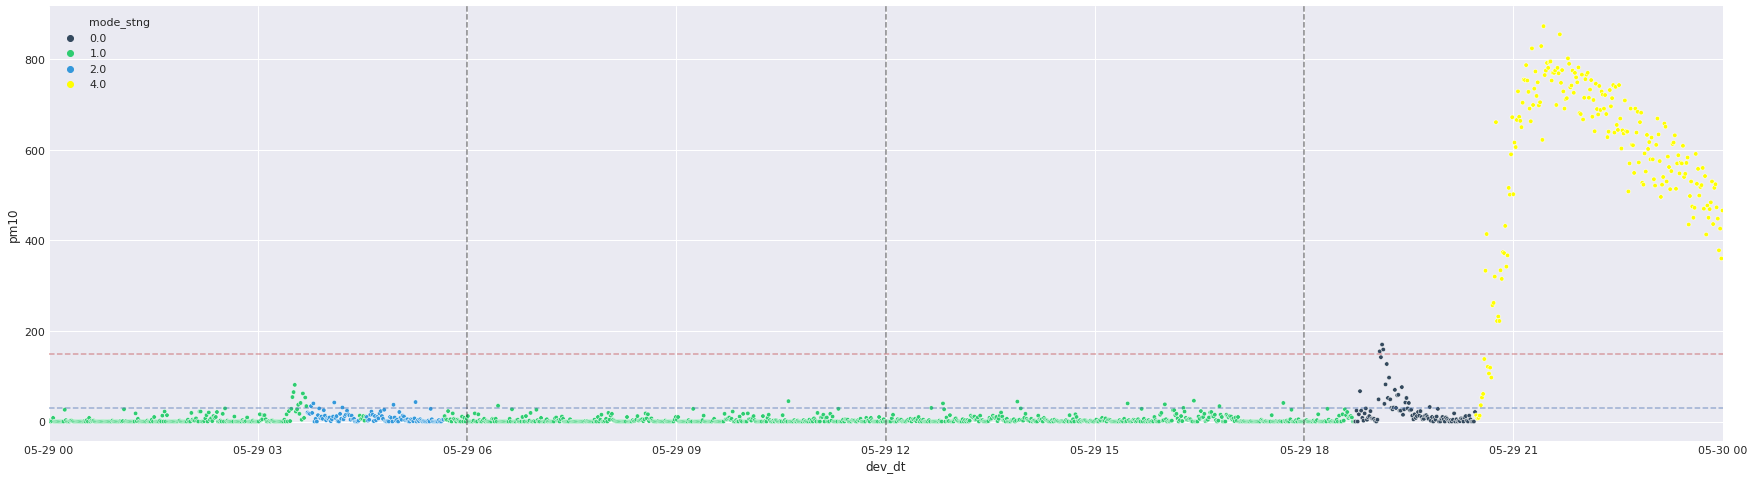

In [91]:
%%time
startDate = '2018-05-29'
endDate   = '2018-05-30'

target_device_data = device_data[-19][device_data[-19]['dev_dt'].between(startDate, endDate)]

fig = plt.figure(figsize=(30,8))
# Initialize the figure
palette = sns.color_palette()
sns.set_palette(colors)
plt.style.use('seaborn-darkgrid')
modes = target_device_data['mode_stng'].unique()
modes.sort()

print(modes)
print([colors[int(n)] for n in modes if not np.isnan(n)])

kws = dict(s=20, linewidth=.5, edgecolor="w")
ax = sns.scatterplot(x="dev_dt", y="pm10", hue="mode_stng", legend='full', palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_device_data, **kws)
plt.xlim((startDate, endDate))
plt.axhline(30,  color='b', linestyle='--', alpha=0.5)
plt.axhline(150, color='r', linestyle='--', alpha=0.5)
ticks = ax.get_xticks()
plt.axvline(ticks[2], color='k', linestyle='--', alpha=0.5)
plt.axvline(ticks[4], color='k', linestyle='--', alpha=0.5)
plt.axvline(ticks[6], color='k', linestyle='--', alpha=0.5)

target = 19502ETJ1751900053 2018-05-29 2018-05-30


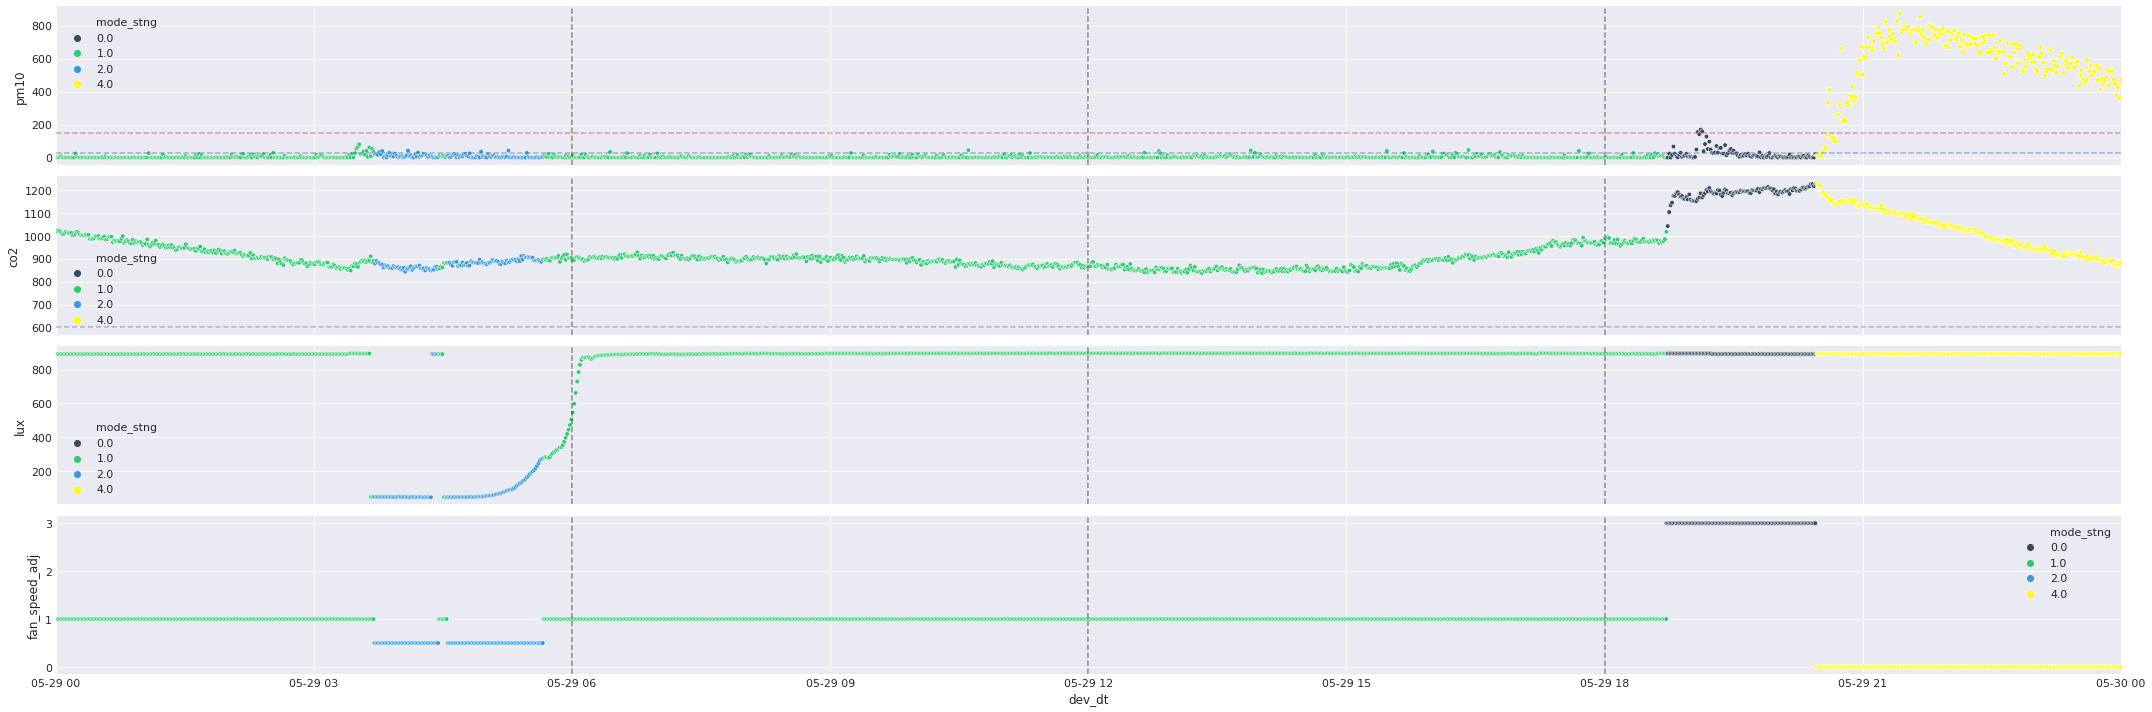

In [92]:
generate_graph(target_device_data, startDate, endDate, outputpath, save=False)

In [ ]:
%%time
colors = ['#34495e','#2ecc71','#3498db', '#000000', '#FFFF00', '#e74c3c','#a9a9a9']
sns.set_palette(colors)
palette = sns.color_palette()
plt.style.use('seaborn-darkgrid')
kws = dict(s=10, linewidth=.5, edgecolor="w")

for i in range(len(selected_devices)):
    print(i+1, device_data[i]['dev_id'].unique(), ' ', device_data[i]['week_no'].nunique())
    fig = plt.figure(figsize=(30,10))
    g = sns.FacetGrid(device_data[i], row="week_no", col='weekday', sharex=False)
    g = g.map(sns.scatterplot, "dev_dt", "pm10", palette=colors[-1], data=device_data[i], **kws)
    g = g.map(plt.axhline, y=30,  color='b', linestyle='--', alpha=0.5)
    g = g.map(plt.axhline, y=150, color='r', linestyle='--', alpha=0.5)
    
    [ax.set_xticklabels([]) for ax in g.axes.flat]
    
    ## limitation
    g.axes[0][1].set_xlim(('2018-05-01 00:00', '2018-05-01 23:59'))
    g.axes[0][2].set_xlim(('2018-05-02 00:00', '2018-05-02 23:59'))
    g.axes[0][3].set_xlim(('2018-05-03 00:00', '2018-05-03 23:59'))
    g.axes[0][4].set_xlim(('2018-05-04 00:00', '2018-05-04 23:59'))
    g.axes[0][5].set_xlim(('2018-05-05 00:00', '2018-05-05 23:59'))
    g.axes[0][6].set_xlim(('2018-05-06 00:00', '2018-05-06 23:59'))
    g.axes[1][0].set_xlim(('2018-05-07 00:00', '2018-05-07 23:59'))
    g.axes[1][1].set_xlim(('2018-05-08 00:00', '2018-05-08 23:59'))
    g.axes[1][2].set_xlim(('2018-05-09 00:00', '2018-05-09 23:59'))
    g.axes[1][3].set_xlim(('2018-05-10 00:00', '2018-05-10 23:59'))
    g.axes[1][4].set_xlim(('2018-05-11 00:00', '2018-05-11 23:59'))
    g.axes[1][5].set_xlim(('2018-05-12 00:00', '2018-05-12 23:59'))
    g.axes[1][6].set_xlim(('2018-05-13 00:00', '2018-05-13 23:59'))
    g.axes[2][0].set_xlim(('2018-05-14 00:00', '2018-05-14 23:59'))
    g.axes[2][1].set_xlim(('2018-05-15 00:00', '2018-05-15 23:59'))
    g.axes[2][2].set_xlim(('2018-05-16 00:00', '2018-05-16 23:59'))
    g.axes[2][3].set_xlim(('2018-05-17 00:00', '2018-05-17 23:59'))
    g.axes[2][4].set_xlim(('2018-05-18 00:00', '2018-05-18 23:59'))
    g.axes[2][5].set_xlim(('2018-05-19 00:00', '2018-05-19 23:59'))
    g.axes[2][6].set_xlim(('2018-05-20 00:00', '2018-05-20 23:59'))
    g.axes[3][0].set_xlim(('2018-05-21 00:00', '2018-05-21 23:59'))
    g.axes[3][1].set_xlim(('2018-05-22 00:00', '2018-05-22 23:59'))
    g.axes[3][2].set_xlim(('2018-05-23 00:00', '2018-05-23 23:59'))
    g.axes[3][3].set_xlim(('2018-05-24 00:00', '2018-05-24 23:59'))
    g.axes[3][4].set_xlim(('2018-05-25 00:00', '2018-05-25 23:59'))
    g.axes[3][5].set_xlim(('2018-05-26 00:00', '2018-05-26 23:59'))
    g.axes[3][6].set_xlim(('2018-05-27 00:00', '2018-05-27 23:59'))
    if device_data[i]['week_no'].nunique() == 5:
        g.axes[4][0].set_xlim(('2018-05-28 00:00', '2018-05-28 23:59'))
        g.axes[4][1].set_xlim(('2018-05-29 00:00', '2018-05-29 23:59'))
        g.axes[4][2].set_xlim(('2018-05-30 00:00', '2018-05-30 23:59'))
        g.axes[4][3].set_xlim(('2018-05-31 00:00', '2018-05-31 23:59'))

    g.savefig(outputpath + selected_devices[i] + '_1mon_by_day.png')

    # plt.ylim((0,400))
    # g.savefig(outputpath + selected_devices[0] + '_cut_1mon_by_day.png')
    plt.close('all')

In [1]:
def generate_graph(data, s_date, e_date, path, save=False):
    target_data = data[data['dev_dt'].between(s_date, e_date)]
    if not os.path.exists(path + data['dev_id'].unique()[0]):
        os.makedirs(path + data['dev_id'].unique()[0])
        
    ## graph configure
    # 3 is nothing #000000
    colors = ['#34495e','#2ecc71','#3498db', '#000000', '#FFFF00', '#e74c3c','#a9a9a9']
    sns.set_palette(colors)
    plt.style.use('seaborn-darkgrid')
    kws = dict(s=20, linewidth=.5, edgecolor="w")
    modes = target_data['mode_stng'].unique()
    modes.sort()
    
    print(data['dev_id'].unique()[0], s_date, e_date)
    
    fig = plt.figure(figsize=(30,10))
    axe01 = plt.subplot2grid((4,4), (0,0), rowspan = 1, colspan = 4)
    if len(modes) == 1:
        if np.isnan(modes[0]):
            sns.scatterplot(x="dev_dt", y="pm10", hue="mode_stng", palette=colors[-1], data=target_data, legend='full',**kws)
        else:
            sns.scatterplot(x="dev_dt", y="pm10", hue="mode_stng", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="pm10", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
    plt.axhline(30,  color='b', linestyle='--', alpha=0.5)
    plt.axhline(150,  color='r', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
    axe01.xaxis.label.set_visible(False)
    axe01.xaxis.set_ticklabels([])
    plt.xlim((s_date, e_date))

    axe02 = plt.subplot2grid((4,4), (1,0), rowspan = 1, colspan = 4)
    if len(modes) == 1:
        if np.isnan(modes[0]):
            sns.scatterplot(x="dev_dt", y="co2", hue="mode_stng", palette=colors[-1], data=target_data, legend='full',**kws)
        else:
            sns.scatterplot(x="dev_dt", y="co2", hue="mode_stng", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="co2", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
    plt.axhline(600,  color='b', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
    axe02.xaxis.label.set_visible(False)
    axe02.xaxis.set_ticklabels([])
    plt.xlim((s_date, e_date))

    axe03 = plt.subplot2grid((4,4), (2,0), rowspan = 1, colspan = 4)
    if len(modes) == 1:
        if np.isnan(modes[0]):
            sns.scatterplot(x="dev_dt", y="lux", palette=colors[-1], data=target_data, legend='full',**kws)
        else:
            sns.scatterplot(x="dev_dt", y="lux",  hue="mode_stng", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="lux", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
    axe03.xaxis.label.set_visible(False)
    axe03.xaxis.set_ticklabels([])
    plt.xlim((s_date, e_date))

    axe04 = plt.subplot2grid((4,4), (3,0), rowspan = 1, colspan = 4)
    if len(modes) == 1:
        if np.isnan(modes[0]):
            sns.scatterplot(x="dev_dt", y="fan_speed_adj", palette=colors[-1], data=target_data, legend='full',**kws)
        else:
            sns.scatterplot(x="dev_dt", y="fan_speed_adj", hue="mode_stng", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="fan_speed_adj", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
    plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
    plt.xlim((s_date, e_date))
    axe04.set_yticks([0, 1, 2, 3])
    
    plt.tight_layout()
    if save:
        fig.savefig(path + data['dev_id'].unique()[0] + '/' + s_date.strftime('%Y%m%d') +'.png')
        plt.close('all')

In [118]:
%%time 
[generate_graph(device_data[i], s_date, e_date, './', save=True) for i in range(len(device_data)) for s_date, e_date in zip(s_list, e_list)]

target = 19302ETJ1731700128 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 19302ETJ1731700128 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 19302ETJ1731700128 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 19302ETJ1731700128 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 19302ETJ1731700128 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 19302ETJ1731700128 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 19302ETJ1731700128 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 19302ETJ1731700128 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 19302ETJ1731700128 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 19302ETJ1731700128 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 19302ETJ1731700128 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 19302ETJ1731700128 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 19302ETJ1731700128 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 19302ETJ1731700128 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 19302ETJ1731700128 2018-05-15 00:00:00 

target = 19302ETJ1731700122 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 19302ETJ1731700122 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 19302ETJ1731700122 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 17202D8F1692800046 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 17202D8F1692800046 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 17202D8F1692800046 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 17202D8F1692800046 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 17202D8F1692800046 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 17202D8F1692800046 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 17202D8F1692800046 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 17202D8F1692800046 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 17202D8F1692800046 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 17202D8F1692800046 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 17202D8F1692800046 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 17202D8F1692800046 2018-05-12 00:00:00 

target = 17302D8F1661600051 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 17302D8F1661600051 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 17302D8F1661600051 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 17302D8F1661600051 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 17302D8F1661600051 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 17302D8F1661600051 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 17202D8F16B0900035 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 17202D8F16B0900035 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 17202D8F16B0900035 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 17202D8F16B0900035 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 17202D8F16B0900035 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 17202D8F16B0900035 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 17202D8F16B0900035 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 17202D8F16B0900035 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 17202D8F16B0900035 2018-05-09 00:00:00 

target = 19202D8F1662000132 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 19202D8F1662000132 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 19202D8F1662000132 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 19202D8F1662000132 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 19202D8F1662000132 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 19202D8F1662000132 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 19202D8F1662000132 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 19202D8F1662000132 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 19202D8F1662000132 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 17202D8F1661600020 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 17202D8F1661600020 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 17202D8F1661600020 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 17202D8F1661600020 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 17202D8F1661600020 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 17202D8F1661600020 2018-05-06 00:00:00 

target = 17202ETK1762300023 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 17202ETK1762300023 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 17202ETK1762300023 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 17202ETK1762300023 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 17202ETK1762300023 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 17202ETK1762300023 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 17202ETK1762300023 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 17202ETK1762300023 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 17202ETK1762300023 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 17202ETK1762300023 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 17202ETK1762300023 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 17202ETK1762300023 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 16402D8F15B2400056 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 16402D8F15B2400056 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 16402D8F15B2400056 2018-05-03 00:00:00 

target = 16402D8F15A0700060 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 16402D8F15A0700060 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 16402D8F15A0700060 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 16402D8F15A0700060 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 16402D8F15A0700060 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 16402D8F15A0700060 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 16402D8F15A0700060 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 16402D8F15A0700060 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 16402D8F15A0700060 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 16402D8F15A0700060 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 16402D8F15A0700060 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 16402D8F15A0700060 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 16402D8F15A0700060 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 16402D8F15A0700060 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 16402D8F15A0700060 2018-05-31 00:00:00 

target = 16102D8F15A0700026 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 16102D8F15A0700026 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 16102D8F15A0700026 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 16102D8F15A0700026 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 16102D8F15A0700026 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 16102D8F15A0700026 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 16102D8F15A0700026 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 16102D8F15A0700026 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 16102D8F15A0700026 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 16102D8F15A0700026 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 16102D8F15A0700026 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 16102D8F15A0700026 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 16102D8F15A0700026 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 16102D8F15A0700026 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 16102D8F15A0700026 2018-05-28 00:00:00 

target = 17102D8F1660900057 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 17102D8F1660900057 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 17102D8F1660900057 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 17102D8F1660900057 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 17102D8F1660900057 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 17102D8F1660900057 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 17102D8F1660900057 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 17102D8F1660900057 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 17102D8F1660900057 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 17102D8F1660900057 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 17102D8F1660900057 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 17102D8F1660900057 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 17102D8F1660900057 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 17102D8F1660900057 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 17102D8F1660900057 2018-05-25 00:00:00 

target = 17102ETJ1711000022 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 17102ETJ1711000022 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 17102ETJ1711000022 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 17102ETJ1711000022 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 17102ETJ1711000022 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 17102ETJ1711000022 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 17102ETJ1711000022 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 17102ETJ1711000022 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 17102ETJ1711000022 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 17102ETJ1711000022 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 17102ETJ1711000022 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 17102ETJ1711000022 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 17102ETJ1711000022 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 17102ETJ1711000022 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 17102ETJ1711000022 2018-05-22 00:00:00 

target = 19402D8F1752000099 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 19402D8F1752000099 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 19402D8F1752000099 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 19402D8F1752000099 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 19402D8F1752000099 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 19402D8F1752000099 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 19402D8F1752000099 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 19402D8F1752000099 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 19402D8F1752000099 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 19402D8F1752000099 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 19402D8F1752000099 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 19402D8F1752000099 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 19402D8F1752000099 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 19402D8F1752000099 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 19402D8F1752000099 2018-05-19 00:00:00 

target = 15902D8F1632600052 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 15902D8F1632600052 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 15902D8F1632600052 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 15902D8F1632600052 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 15902D8F1632600052 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 15902D8F1632600052 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 15902D8F1632600052 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 15902D8F1632600052 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 15902D8F1632600052 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 15902D8F1632600052 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 15902D8F1632600052 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 15902D8F1632600052 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 15902D8F1632600052 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 15902D8F1632600052 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 15902D8F1632600052 2018-05-16 00:00:00 

target = 17302D8F1642600064 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 17302D8F1642600064 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 19202D8F1661700405 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 19202D8F1661700405 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 19202D8F1661700405 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 19202D8F1661700405 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 19202D8F1661700405 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 19202D8F1661700405 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 19202D8F1661700405 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 19202D8F1661700405 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 19202D8F1661700405 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 19202D8F1661700405 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 19202D8F1661700405 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 19202D8F1661700405 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 19202D8F1661700405 2018-05-13 00:00:00 

target = 19202D8F1662800382 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 19202D8F1662800382 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 19202D8F1662800382 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 19202D8F1662800382 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 19202D8F1662800382 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 17402D8F1761600024 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 17402D8F1761600024 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 17402D8F1761600024 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 17402D8F1761600024 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 17402D8F1761600024 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 17402D8F1761600024 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 17402D8F1761600024 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 17402D8F1761600024 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 17402D8F1761600024 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 17402D8F1761600024 2018-05-10 00:00:00 

target = 16102D8F15A0700056 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 16102D8F15A0700056 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 16102D8F15A0700056 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 16102D8F15A0700056 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 16102D8F15A0700056 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 16102D8F15A0700056 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 16102D8F15A0700056 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 16102D8F15A0700056 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 16302D8F15B1300011 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 16302D8F15B1300011 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 16302D8F15B1300011 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 16302D8F15B1300011 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 16302D8F15B1300011 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 16302D8F15B1300011 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 16302D8F15B1300011 2018-05-07 00:00:00 

target = 19302D8F1731700009 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 19302D8F1731700009 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 19302D8F1731700009 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 19302D8F1731700009 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 19302D8F1731700009 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 19302D8F1731700009 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 19302D8F1731700009 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 19302D8F1731700009 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 19302D8F1731700009 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 19302D8F1731700009 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 19302D8F1731700009 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 17302D8F1732300101 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 17302D8F1732300101 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 17302D8F1732300101 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 17302D8F1732300101 2018-05-04 00:00:00 

target = 17102D8F1710900007 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 17102D8F1710900007 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 17102D8F1710900007 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 17102D8F1710900007 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 17102D8F1710900007 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 17102D8F1710900007 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 17102D8F1710900007 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 17102D8F1710900007 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 17102D8F1710900007 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 17102D8F1710900007 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 17102D8F1710900007 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 17102D8F1710900007 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 17102D8F1710900007 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 17102D8F1710900007 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 17202D8F1651000008 2018-05-01 00:00:00 

target = 17302D8F1732300048 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 17302D8F1732300048 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 17302D8F1732300048 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 17302D8F1732300048 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 17302D8F1732300048 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 17302D8F1732300048 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 17302D8F1732300048 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 17302D8F1732300048 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 17302D8F1732300048 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 17302D8F1732300048 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 17302D8F1732300048 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 17302D8F1732300048 2018-05-26 00:00:00 2018-05-27 00:00:00
target = 17302D8F1732300048 2018-05-27 00:00:00 2018-05-28 00:00:00
target = 17302D8F1732300048 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 17302D8F1732300048 2018-05-29 00:00:00 

target = 15902D8F1611100600 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 15902D8F1611100600 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 15902D8F1611100600 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 15902D8F1611100600 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 15902D8F1611100600 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 15902D8F1611100600 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 15902D8F1611100600 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 15902D8F1611100600 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 15902D8F1611100600 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 15902D8F1611100600 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 15902D8F1611100600 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 15902D8F1611100600 2018-05-23 00:00:00 2018-05-24 00:00:00
target = 15902D8F1611100600 2018-05-24 00:00:00 2018-05-25 00:00:00
target = 15902D8F1611100600 2018-05-25 00:00:00 2018-05-26 00:00:00
target = 15902D8F1611100600 2018-05-26 00:00:00 

target = 17202D8F1642800002 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 17202D8F1642800002 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 17202D8F1642800002 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 17202D8F1642800002 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 17202D8F1642800002 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 17202D8F1642800002 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 17202D8F1642800002 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 17202D8F1642800002 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 17202D8F1642800002 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 17202D8F1642800002 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 17202D8F1642800002 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 17202D8F1642800002 2018-05-20 00:00:00 2018-05-21 00:00:00
target = 17202D8F1642800002 2018-05-21 00:00:00 2018-05-22 00:00:00
target = 17202D8F1642800002 2018-05-22 00:00:00 2018-05-23 00:00:00
target = 17202D8F1642800002 2018-05-23 00:00:00 

target = 17302D8F1651900134 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 17302D8F1651900134 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 17302D8F1651900134 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 17302D8F1651900134 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 17302D8F1651900134 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 17302D8F1651900134 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 17302D8F1651900134 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 17302D8F1651900134 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 17302D8F1651900134 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 17302D8F1651900134 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 17302D8F1651900134 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 17302D8F1651900134 2018-05-17 00:00:00 2018-05-18 00:00:00
target = 17302D8F1651900134 2018-05-18 00:00:00 2018-05-19 00:00:00
target = 17302D8F1651900134 2018-05-19 00:00:00 2018-05-20 00:00:00
target = 17302D8F1651900134 2018-05-20 00:00:00 

target = 17102ER016A1000020 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 17102ER016A1000020 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 17102ER016A1000020 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 17102ER016A1000020 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 17102ER016A1000020 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 17102ER016A1000020 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 17102ER016A1000020 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 17102ER016A1000020 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 17102ER016A1000020 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 17102ER016A1000020 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 17102ER016A1000020 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 17102ER016A1000020 2018-05-14 00:00:00 2018-05-15 00:00:00
target = 17102ER016A1000020 2018-05-15 00:00:00 2018-05-16 00:00:00
target = 17102ER016A1000020 2018-05-16 00:00:00 2018-05-17 00:00:00
target = 17102ER016A1000020 2018-05-17 00:00:00 

target = 19302D8F16C2600054 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 17102D8F16C1400039 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 17102D8F16C1400039 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 17102D8F16C1400039 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 17102D8F16C1400039 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 17102D8F16C1400039 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 17102D8F16C1400039 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 17102D8F16C1400039 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 17102D8F16C1400039 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 17102D8F16C1400039 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 17102D8F16C1400039 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 17102D8F16C1400039 2018-05-11 00:00:00 2018-05-12 00:00:00
target = 17102D8F16C1400039 2018-05-12 00:00:00 2018-05-13 00:00:00
target = 17102D8F16C1400039 2018-05-13 00:00:00 2018-05-14 00:00:00
target = 17102D8F16C1400039 2018-05-14 00:00:00 

target = 16102D8F15B2000163 2018-05-28 00:00:00 2018-05-29 00:00:00
target = 16102D8F15B2000163 2018-05-29 00:00:00 2018-05-30 00:00:00
target = 16102D8F15B2000163 2018-05-30 00:00:00 2018-05-31 00:00:00
target = 16102D8F15B2000163 2018-05-31 00:00:00 2018-06-01 00:00:00
target = 16102D8F15A2200040 2018-05-01 00:00:00 2018-05-02 00:00:00
target = 16102D8F15A2200040 2018-05-02 00:00:00 2018-05-03 00:00:00
target = 16102D8F15A2200040 2018-05-03 00:00:00 2018-05-04 00:00:00
target = 16102D8F15A2200040 2018-05-04 00:00:00 2018-05-05 00:00:00
target = 16102D8F15A2200040 2018-05-05 00:00:00 2018-05-06 00:00:00
target = 16102D8F15A2200040 2018-05-06 00:00:00 2018-05-07 00:00:00
target = 16102D8F15A2200040 2018-05-07 00:00:00 2018-05-08 00:00:00
target = 16102D8F15A2200040 2018-05-08 00:00:00 2018-05-09 00:00:00
target = 16102D8F15A2200040 2018-05-09 00:00:00 2018-05-10 00:00:00
target = 16102D8F15A2200040 2018-05-10 00:00:00 2018-05-11 00:00:00
target = 16102D8F15A2200040 2018-05-11 00:00:00 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## for testing the function

In [106]:
i = 17
d = 29
s_date = s_list[d]
e_date = e_list[d]
target_data = device_data[i][device_data[i]['dev_dt'].between(s_date, e_date)]

In [107]:
target_data

,dev_id,dev_dt,pm25,pm10,voc_ref,voc_now,humi,temp,lux,co2,...,eco_mode_stng,iaq_idx_y,oaq_idx,ventil_alrm,cover_alrm_l,cover_alrm_r,dt_y,grade_pm10,week_no,weekday


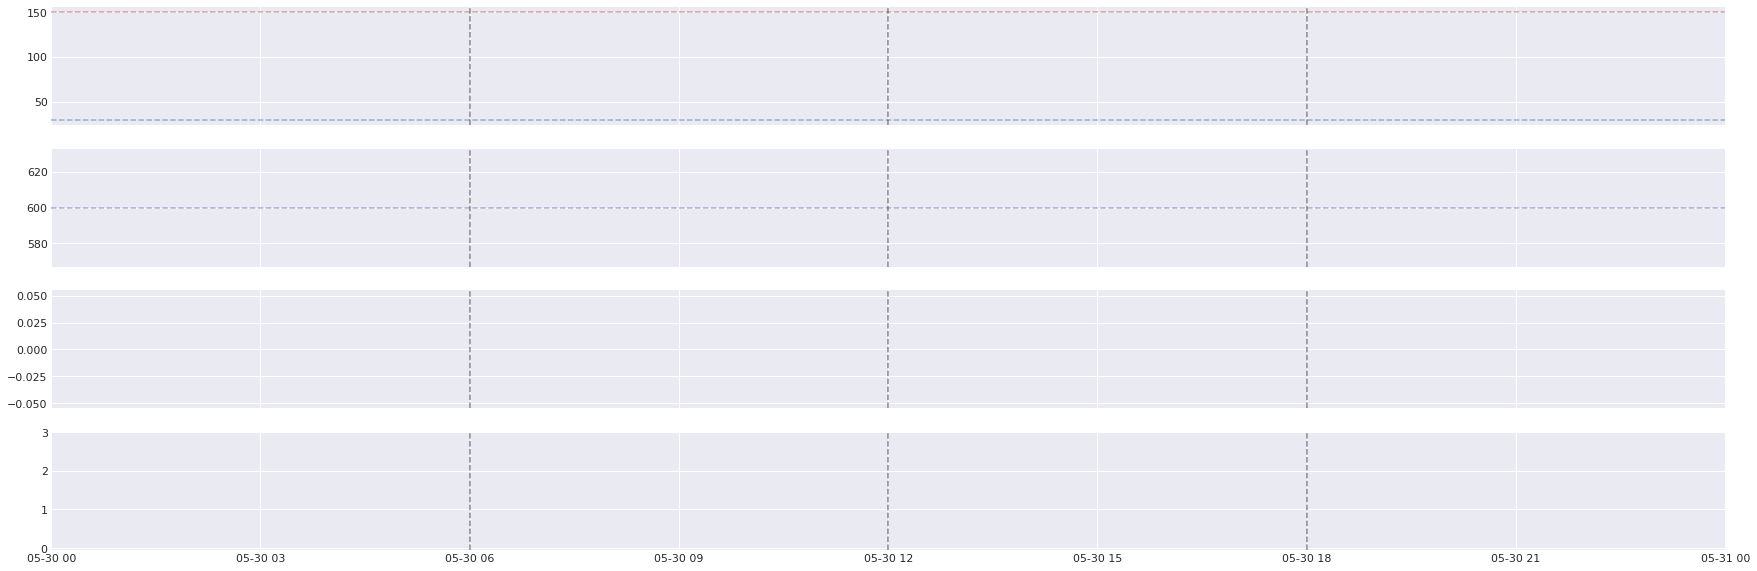

In [114]:
plt.style.use('seaborn-darkgrid')
kws = dict(s=20, linewidth=.5, edgecolor="w")
modes = target_data['mode_stng'].unique()
modes.sort()

fig = plt.figure(figsize=(30,10))
axe01 = plt.subplot2grid((4,4), (0,0), rowspan = 1, colspan = 4)
if len(modes) == 1:
    if np.isnan(modes[0]):
        sns.scatterplot(x="dev_dt", y="pm10", palette=colors[-1], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="pm10", hue="mode_stng", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
else:
    sns.scatterplot(x="dev_dt", y="pm10", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
plt.axhline(30,  color='b', linestyle='--', alpha=0.5)
plt.axhline(150,  color='r', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
axe01.xaxis.label.set_visible(False)
axe01.xaxis.set_ticklabels([])
plt.xlim((s_date, e_date))

axe02 = plt.subplot2grid((4,4), (1,0), rowspan = 1, colspan = 4)
if len(modes) == 1:
    if np.isnan(modes[0]):
        sns.scatterplot(x="dev_dt", y="co2", palette=colors[-1], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="co2", hue="mode_stng", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
else:
    sns.scatterplot(x="dev_dt", y="co2", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
plt.axhline(600,  color='b', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
axe02.xaxis.label.set_visible(False)
axe02.xaxis.set_ticklabels([])
plt.xlim((s_date, e_date))

axe03 = plt.subplot2grid((4,4), (2,0), rowspan = 1, colspan = 4)
if len(modes) == 1:
    if np.isnan(modes[0]):
        sns.scatterplot(x="dev_dt", y="lux", palette=colors[-1], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="lux",  hue="mode_stng", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
else:
    sns.scatterplot(x="dev_dt", y="lux", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
axe03.xaxis.label.set_visible(False)
axe03.xaxis.set_ticklabels([])
plt.xlim((s_date, e_date))

axe04 = plt.subplot2grid((4,4), (3,0), rowspan = 1, colspan = 4)
if len(modes) == 1:
    if np.isnan(modes[0]):
        sns.scatterplot(x="dev_dt", y="fan_speed_adj", palette=colors[-1], data=target_data, legend='full',**kws)
    else:
        sns.scatterplot(x="dev_dt", y="fan_speed_adj", hue="mode_stng", palette=colors[int(modes[0])], data=target_data, legend='full',**kws)
else:
    sns.scatterplot(x="dev_dt", y="fan_speed_adj", hue="mode_stng", palette=[colors[int(n)] for n in modes if not np.isnan(n)], data=target_data, legend='full',**kws)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[2], color='k', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[4], color='k', linestyle='--', alpha=0.5)
plt.axvline(pd.date_range(s_date, e_date, periods=9).tolist()[6], color='k', linestyle='--', alpha=0.5)
plt.xlim((s_date, e_date))
axe04.set_yticks([0, 1, 2, 3])

In [ ]:
pd.date_range(s_date, e_date, periods=9).tolist()

In [ ]:
generate_graph(device_data[4], s_list[6], e_list[6], outputpath)